In [19]:
import os
import sys
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(f"{os.getcwd()}/../")

from processing.utils import CleanUp, SNOWBALL_STEMMER
from database.models import RawHashtagComments, UserLocation

%matplotlib inline

normalizar = CleanUp(stemmer=SNOWBALL_STEMMER)

In [34]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [61]:
print(f"Qtde. de Comentarios            : {len(hashtags_)}")
print(f"Qtde. de Comentarios positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentarios negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuarios geolocalizados: {len(users_)}")
print(f"Qtde. de Usuarios em SP         : {len(users_[users_['state'] == 'SP'])}")

Qtde. de Comentarios            : 162866
Qtde. de Comentarios positivos  : 66837
Qtde. de Comentarios negativos  : 96029
----------------------------------------
Qtde. de Usuarios geolocalizados: 39148
Qtde. de Usuarios em SP         : 7624


Exemplos de comentarios com suas classificacoes:

In [62]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"- {row.classify} <=> {row.comment}")

- negativo <=> Em resposta a  @vilanovacaio1 Quando eu fecho os olhos eu fico com falta de ar.
- positivo <=> febre, dor de cabeça forte, dor na costa e falta de apetite noite ótima
- negativo <=> aquela dor de garganta por segurar o choro
- negativo <=> Em resposta a  @ReinaldoLeandr8  @GabrielSpop  e  @felipeneto Quando vc estiver fodido na UTI, abra mão do seu respirador artificial. Além do mais, seria um prazer ver você morrendo com falta de ar.   Mongolóide!!!
- negativo <=> To cm dor de garganta, tomara q eu tenha pegado corona de uma vez kkk


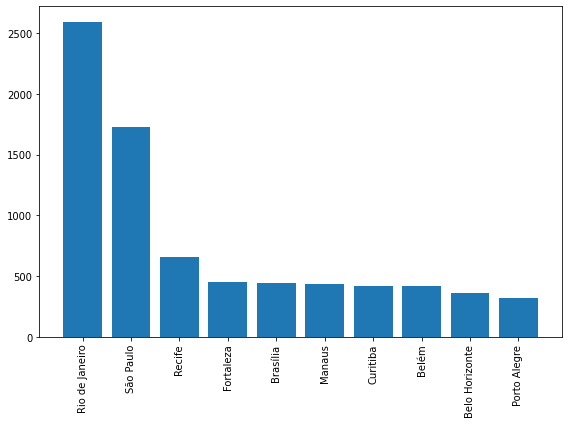

In [106]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
sp = users_.copy()
sp['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nsp = hashtags_[(hashtags_['username'].isin(sp['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
sp = sp[sp['username'].isin(nsp)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
sp = sp.groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)
# Grafico
plt.figure(figsize=(8, 6))
plt.bar(sp['city'][:10], sp['count'][:10])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()